# Policy Analysis Notebook

The purpose of this notebook is to facilitate the generation of shared micro-mobility policy analysis.
It serves as the central hub from which parameters are declared and subsequent functions for data processing, analysis, and visualisation are run from, while keeping the code and "back-end" processes hidden and concise.

### Imports

In [1]:
import datetime as dt
import style
from scripts.api_smhi_weather import *
from scripts.data_processing import *
from scripts.data_visualisations import *

### Policy Parameters

**Path**: path to where the trip data is located, ideally placed in /data, and assumed to be a *CSV file*

**City Name**: the place where the policy was implemented

**Before Start / End date**: The timeframe of the selected period before the policy introduction (earliest and latest)

**After Start / End date**: The timeframe of the selected period after the policy introduction (earliest and latest)

**City Coordinates**: The area to which to restrict the policy analysis to, in the following order: North, South, East, West.
Used for data cleaning (i.e. set to broad perimeter if data is already cleaned of spatial outliers), e.g. from previous datasets:
* STH - 59.39, 59.28, 18.18, 17.94;
* GBG - 57.74, 57.67, 12.02, 11.90

In [2]:
data_path = 'data/data_raw.csv'
city_name = 'Stockholm'

before_start_date = dt.date(2022, 8, 5)
before_end_date = dt.date(2022, 8, 27)

after_start_date = dt.date(2022, 9, 15)
after_end_date = dt.date(2022, 9, 30)

city_coordinates = (59.39, 59.28, 18.18, 17.94)

### Preprocessing

The data is read and parsed according to the methods in `scripts/data_processing`. A brief visualisation of the distribution over days, weekdays and operators follows as a sanity check.

In [3]:
df = pd.read_csv(data_path)
df = parse_data(df)
df = clean_data(df, city_coordinates)

#Datapoints - total: 519315
#Datapoints -  area filter: 518671
#Datapoints - distance filter: 518671
#Datapoints - speed & time filter: 509751


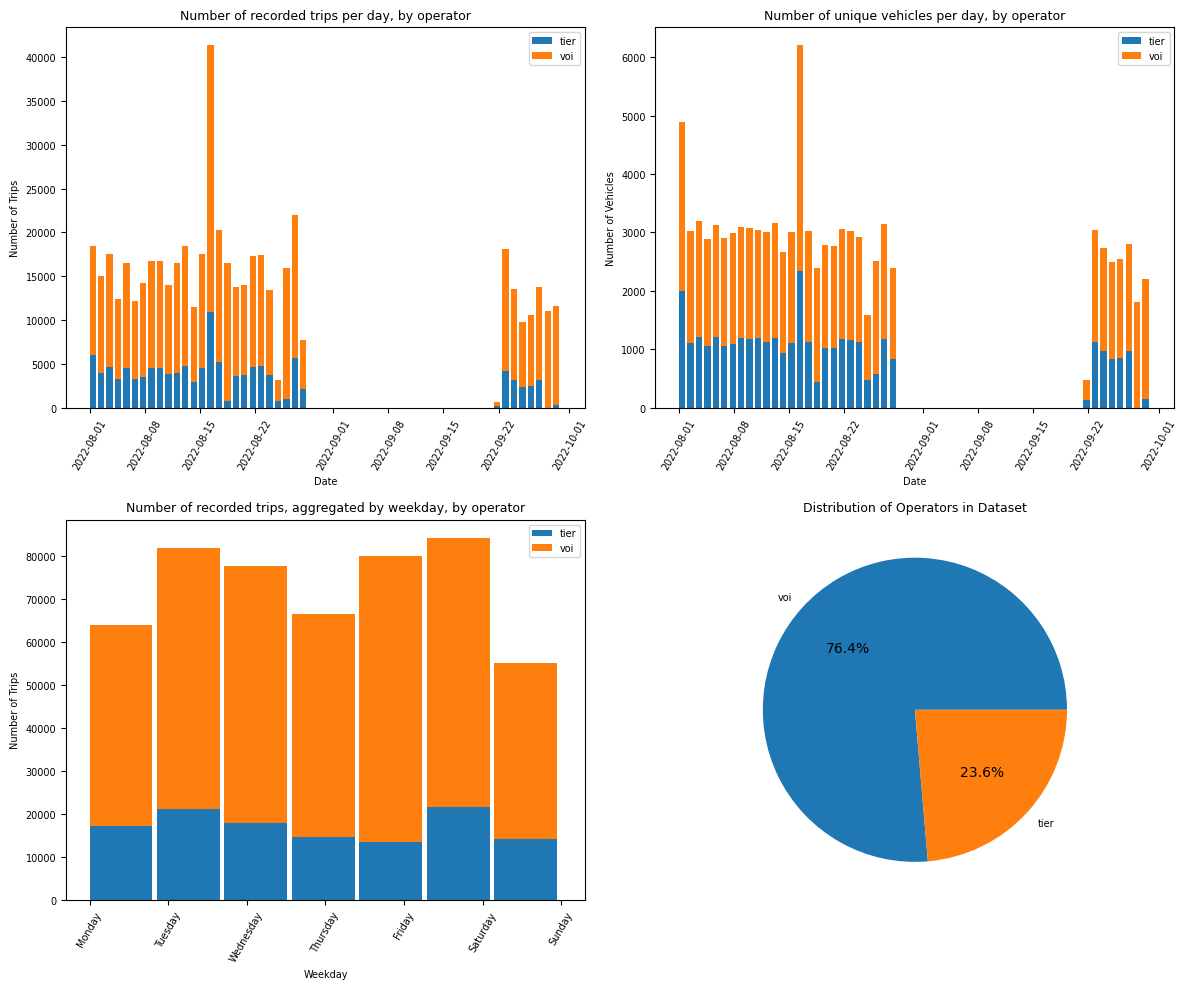

In [4]:
vis_dataset_overview(df, before_start_date, after_end_date)

### Weather Parameters

* explain why weather and how
* explain where to find parameter information
* explain how filtering is done

In [5]:
params = [19, 20, 5]
# calc these
data_mid_lat = 59.33
data_mid_lon = 18.10

weather_stations = get_available_stations(params, data_mid_lat, data_mid_lon)

### Data Selection

* plot weather & missing data points
* split into before and after
* subselect specific days based on weather & missing data points
* enrich filtered data